In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define target
df = pd.read_csv(r"C:\Users\nandi\Documents\ML_CO2_ER\data\df_viscosity_clean.csv")
target = 'viscosity [Pa s]'
X = df.drop(columns=['solvent_ID', 'smiles', 'Binding_Energy_eV', 'solubility_CO2 [mol/L]', target])
y = df[target]

# Apply log transform
y_log = np.log1p(y)  # log1p handles small values safely

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [2]:
y[:5]

0    0.011764
1    0.007448
2    0.002281
3    0.025603
4    0.001110
Name: viscosity [Pa s], dtype: float64

In [3]:
np.log1p(y[:5])

0    0.011696
1    0.007420
2    0.002278
3    0.025281
4    0.001109
Name: viscosity [Pa s], dtype: float64

In [4]:
df[target][:5]

0    0.011764
1    0.007448
2    0.002281
3    0.025603
4    0.001110
Name: viscosity [Pa s], dtype: float64

In [5]:
from xgboost import XGBRegressor

model = XGBRegressor(
    #tree_method='gpu_hist',
    tree_method='hist',
    #device='cuda',
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10,
    learning_rate=0.01,
    n_estimators=500,
    max_depth=6,
    random_state=42
)

model.fit(X_train_scaled, y_train_log)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [6]:
y_pred_log = model.predict(X_test_scaled)
y_train_pred_log = model.predict(X_train_scaled)

# Optional: Clip logs to avoid overflow
# clip_max = 20
# y_pred_log = np.clip(y_pred_log, a_min=None, a_max=clip_max)

# Inverse log1p
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)
y_train_pred = np.expm1(y_train_pred_log)
y_train_act = np.expm1(y_train_log)


In [7]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse1 = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2 = r2_score(y_test, y_pred)

print(f"Fixed RMSE: {rmse:.4f}")
print(f"Fixed RMSE1: {rmse1:.4f}")
print(f"Fixed R²: {r2:.4f}")


Fixed RMSE: 0.0026
Fixed RMSE1: 0.0025
Fixed R²: 0.9080


In [8]:
feature_names = X.columns.tolist()  # This should match the model's input

c:\Users\nandi\Documents\ML_CO2_ER\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


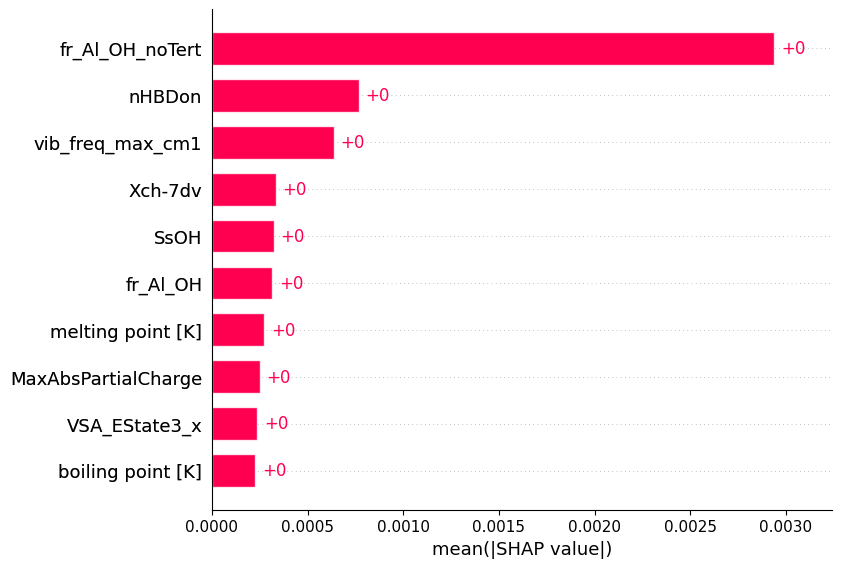

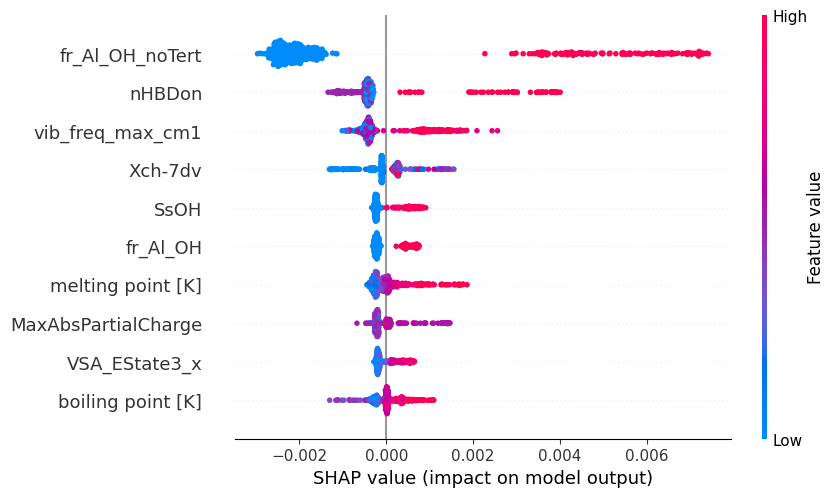

In [9]:
import shap
import numpy as np

# SHAP explainer on log-transformed model
explainer = shap.Explainer(model, X_test_scaled, feature_names=X.columns)
shap_values = explainer(X_test_scaled)

# Compute mean SHAP values (log-space)
mean_shap = np.abs(shap_values.values).mean(axis=0)
top_10_indices = np.argsort(mean_shap)[-10:][::-1]

# Slice SHAP explanation for top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],
    base_values=shap_values.base_values,
    data=shap_values.data[:, top_10_indices],
    feature_names=np.array(shap_values.feature_names)[top_10_indices].tolist()
)

# Plot
shap.plots.bar(shap_values_top10)
shap.plots.beeswarm(shap_values_top10)

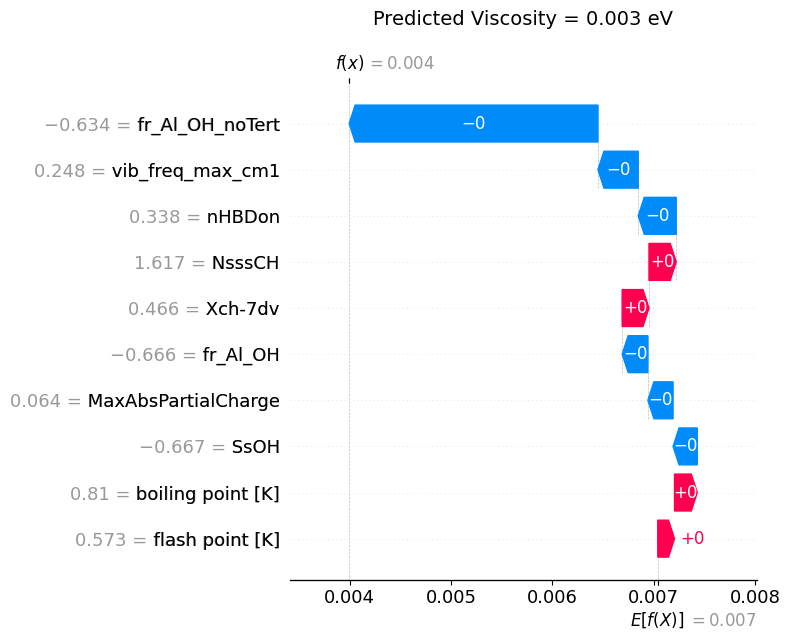

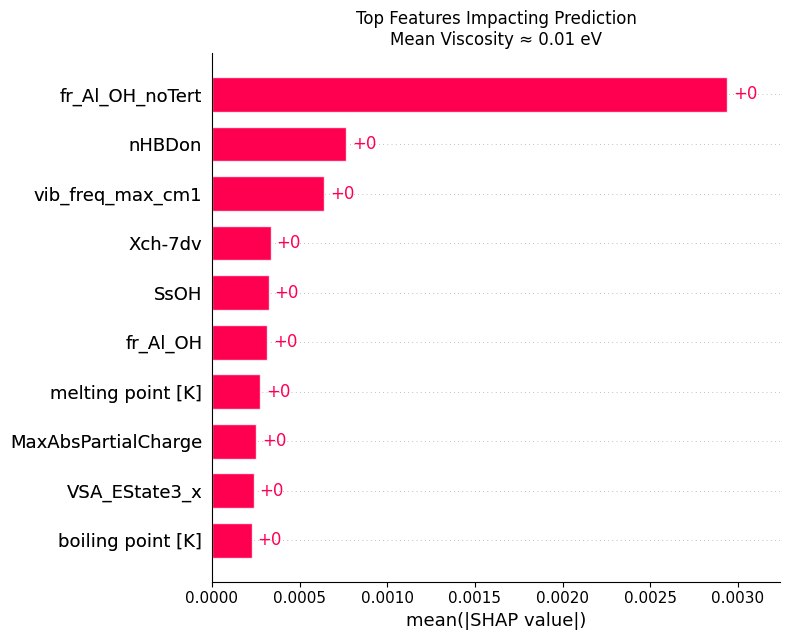

In [ ]:
import matplotlib.pyplot as plt

# Create SHAP explainer
explainer = shap.Explainer(model, X_test_scaled, feature_names=X.columns)
shap_values = explainer(X_test_scaled)

# Choose one sample index
i = 1

sample_shap = shap_values[i]

# Compute predicted log value and actual value
top10_idx = np.argsort(np.abs(sample_shap.values))[-10:][::-1]

# Note: This is only for a sample of data, not the entire data
# Create a new Explanation object with only top 10 features
sample_shap_top10 = shap.Explanation(
    values=sample_shap.values[top10_idx],
    base_values=sample_shap.base_values,
    data=sample_shap.data[top10_idx],
    feature_names=np.array(sample_shap.feature_names)[top10_idx].tolist()
)

log_pred = shap_values.base_values[i] + shap_values.values[i].sum()
actual_pred = np.expm1(log_pred)

# Plotly waterfall plot
fig = shap.plots.waterfall(sample_shap_top10, show=False)
fig.set_title(f"Predicted Viscosity = {actual_pred:.3f} eV", fontsize=14, pad=20)
plt.tight_layout()
plt.show()

mean_shap = np.abs(shap_values.values).mean(axis=0)

top10_global_idx = np.argsort(mean_shap)[-10:][::-1]

shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top10_global_idx],
    base_values=shap_values.base_values,
    data=shap_values.data[:, top10_global_idx],
    feature_names=np.array(shap_values.feature_names)[top10_global_idx].tolist()
)

fig = shap.plots.bar(shap_values_top10, show=False)
fig.set_title(f"Top Features Impacting Prediction\nMean Viscosity ≈ {np.expm1(shap_values.base_values.mean()):.2f} eV", fontsize=12)

plt.tight_layout()
plt.show()

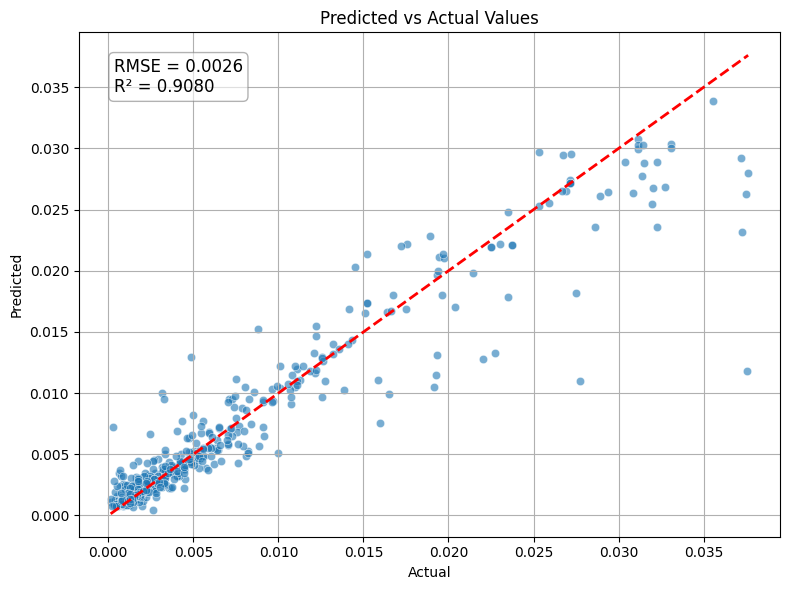

In [12]:
residuals = y_test - y_pred

import matplotlib.pyplot as plt
import seaborn as sns 

# --- A. Predicted vs Actual Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)

# Reference line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', linewidth=2)

# Annotate RMSE and R² inside the plot
plt.text(
    0.05, 0.95,
    f"RMSE = {rmse:.4f}\nR² = {r2:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.6)
)

plt.title("Predicted vs Actual Values")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

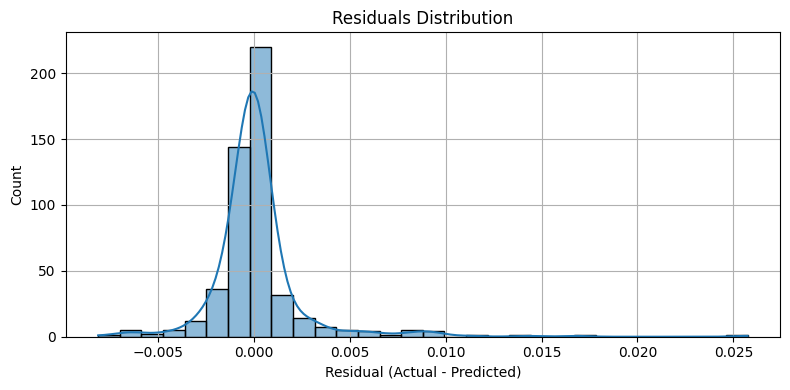

In [13]:
# --- B. Histogram of Residuals ---
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

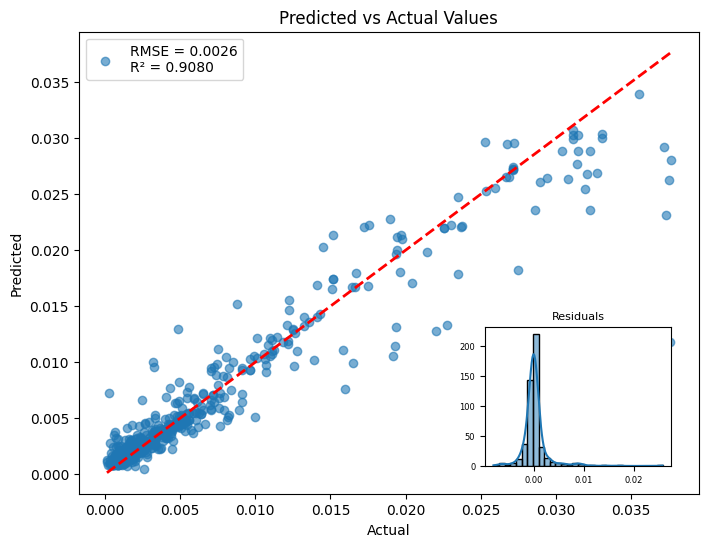

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, y_pred, alpha=0.6)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
ax.set_title("Predicted vs Actual Values")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.legend([f'RMSE = {rmse:.4f}\nR² = {r2:.4f}'], loc='upper left')

# Inset Plot: Residuals Distribution
inset_ax = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=2)
sns.histplot(residuals, bins=30, kde=True, ax=inset_ax)
inset_ax.set_title("Residuals", fontsize=8)
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelsize=6)

C:\Users\nandi\AppData\Local\Temp\ipykernel_3548\1650586806.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


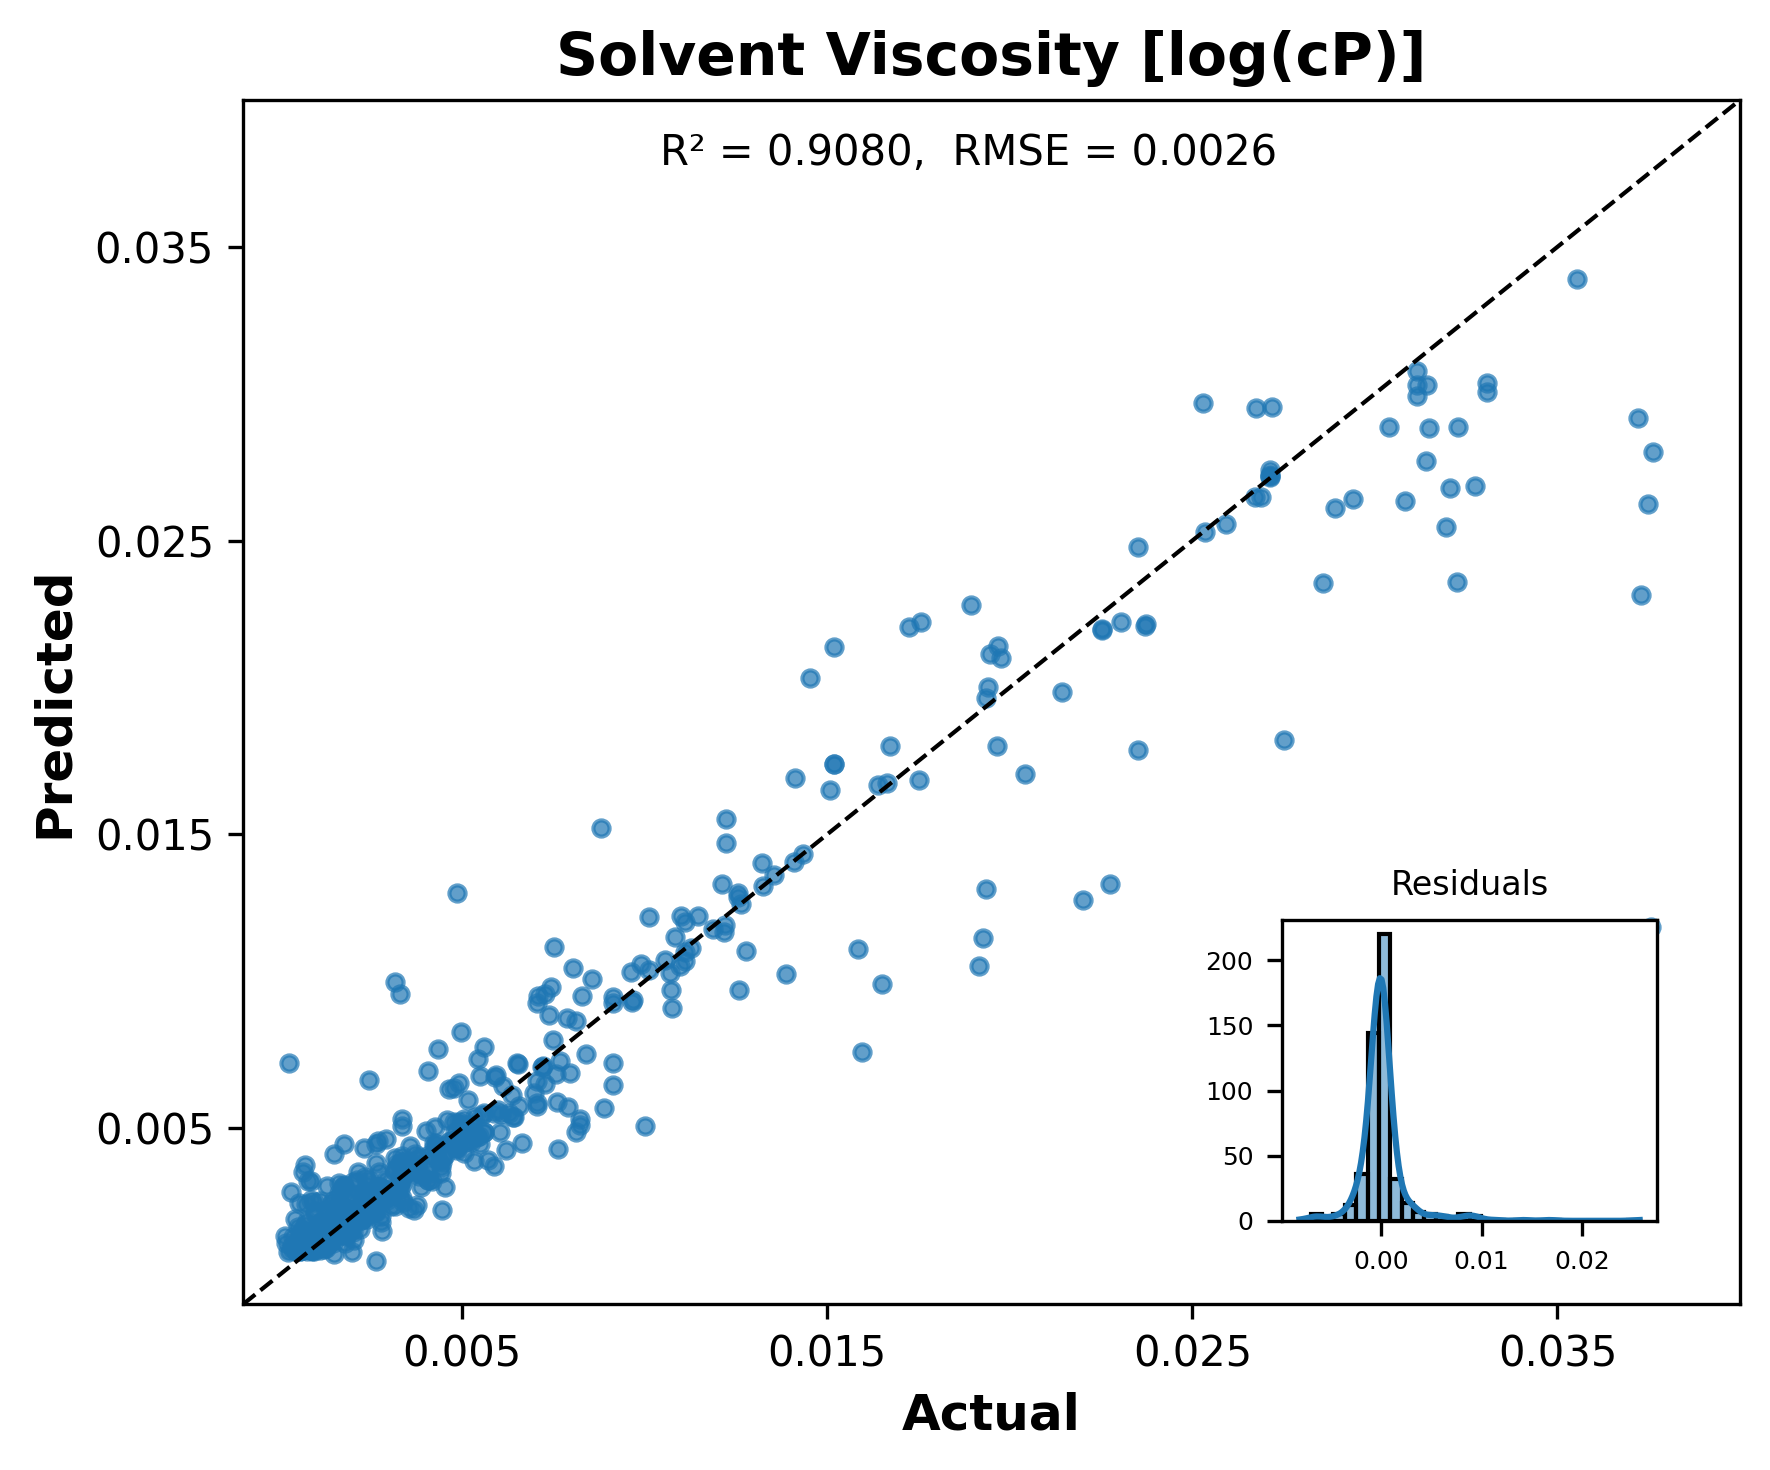

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

# ➤ Scatter plot and diagonal line
ax.scatter(y_test, y_pred, alpha=0.7, s=15)
ax.plot([-0.001, 0.040], [-0.001, 0.040], 'k--', linewidth=1)

# ➤ Main plot labels
ax.set_title("Solvent Viscosity [log(cP)]", fontsize=14, fontweight='bold')
ax.set_xlabel("Actual", fontsize=12, fontweight='bold')
ax.set_ylabel("Predicted", fontsize=12, fontweight='bold')
ax.set_xlim(-0.001, 0.040)
ax.set_ylim(-0.001, 0.040)
ax.set_xticks([0.005, 0.015,0.025,0.035])
ax.set_yticks([0.005, 0.015,0.025,0.035])
ax.tick_params(axis='both', labelsize=10)

# ➤ R² and RMSE just inside top center of axes
x_center = (y_test.min() + y_test.max()) / 2
y_top = y_pred.max() + (y_pred.max() - y_pred.min()) * 0.15
ax.text(x_center, y_top, f"R² = {r2:.4f},  RMSE = {rmse:.4f}",
        fontsize=10, ha='center', va='top')

# ➤ Inset plot for residuals
inset_ax = inset_axes(ax, width="25%", height="25%", loc='lower right', borderpad=2)


sns.histplot(residuals, bins=30, kde=True, ax=inset_ax)
inset_ax.set_title("Residuals", fontsize=8)
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelsize=6)

# ➤ Adjust layout and save
plt.tight_layout()
plt.savefig("solvent_viscosity_fixed.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\nandi\AppData\Local\Temp\ipykernel_3548\2442506040.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


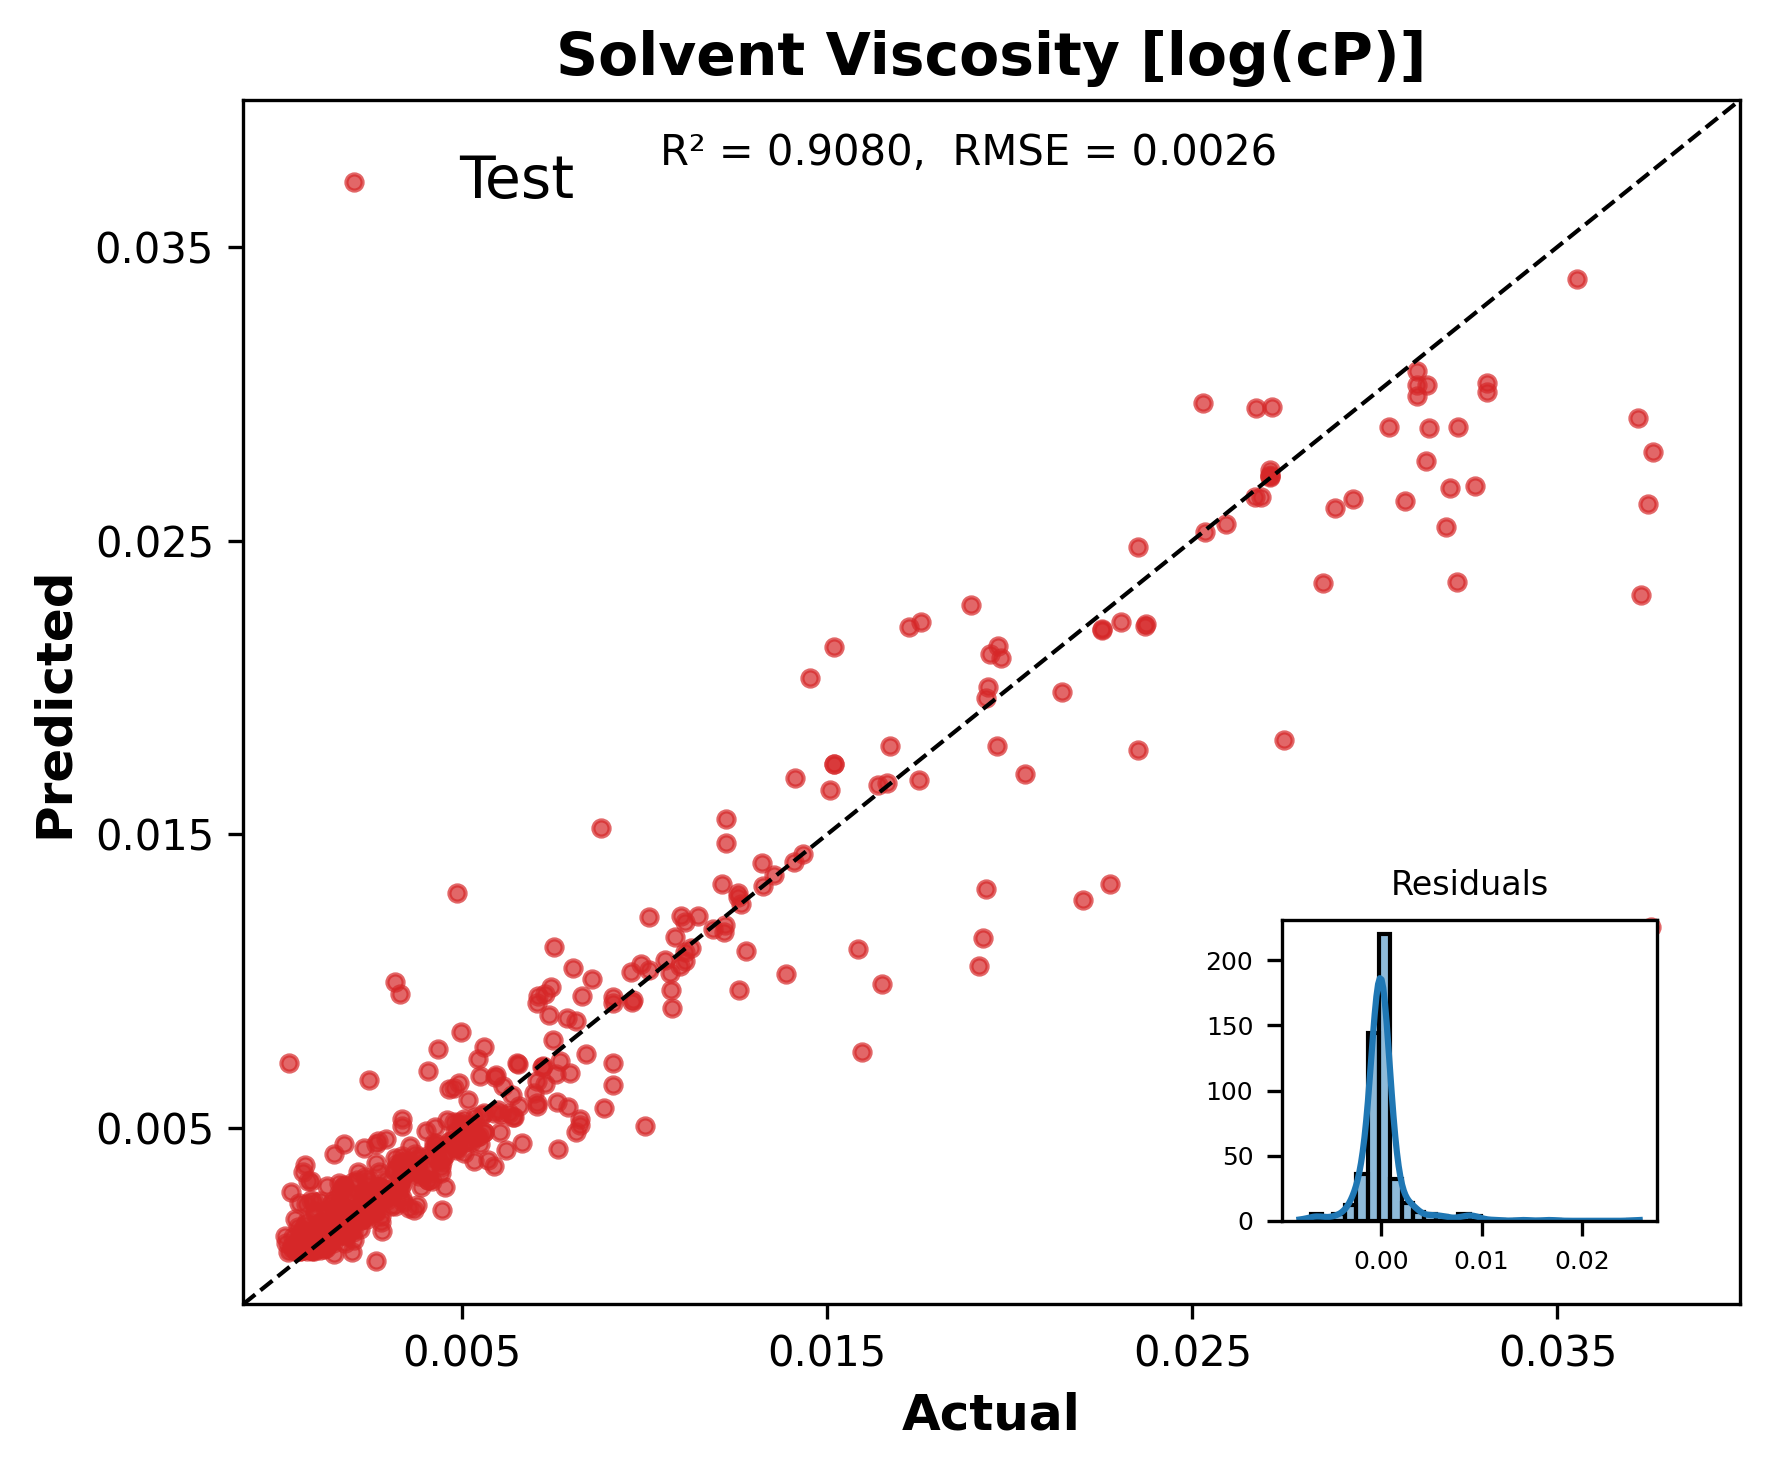

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

# ➤ Scatter plot and diagonal line

ax.scatter(y_test, y_pred, alpha=0.7, s=15, color='tab:red', marker='o', label='Test')
ax.plot([-0.001, 0.040], [-0.001, 0.040], 'k--', linewidth=1)

# ➤ Main plot labels
ax.set_title("Solvent Viscosity [log(cP)]", fontsize=14, fontweight='bold')
ax.set_xlabel("Actual", fontsize=12, fontweight='bold')
ax.set_ylabel("Predicted", fontsize=12, fontweight='bold')
ax.set_xlim(-0.001, 0.040)
ax.set_ylim(-0.001, 0.040)
ax.set_xticks([0.005, 0.015,0.025,0.035])
ax.set_yticks([0.005, 0.015,0.025,0.035])
ax.tick_params(axis='both', labelsize=10)

# ➤ R² and RMSE just inside top center of axes
x_center = (y_test.min() + y_test.max()) / 2
y_top = y_pred.max() + (y_pred.max() - y_pred.min()) * 0.15
ax.text(x_center, y_top, f"R² = {r2:.4f},  RMSE = {rmse:.4f}",
        fontsize=10, ha='center', va='top')

# ➤ Legend for Train/Test, slightly lowered at top-left, no frame
ax.legend(loc='upper left', fontsize=14, frameon=False)


# ➤ Inset plot for residuals
inset_ax = inset_axes(ax, width="25%", height="25%", loc='lower right', borderpad=2)


sns.histplot(residuals, bins=30, kde=True, ax=inset_ax)
inset_ax.set_title("Residuals", fontsize=8)
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelsize=6)

# ➤ Adjust layout and save
plt.tight_layout()
plt.savefig("solvent_viscosity_fixed_TT.png", dpi=300, bbox_inches='tight')
plt.show()




C:\Users\nandi\AppData\Local\Temp\ipykernel_3548\2552240196.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


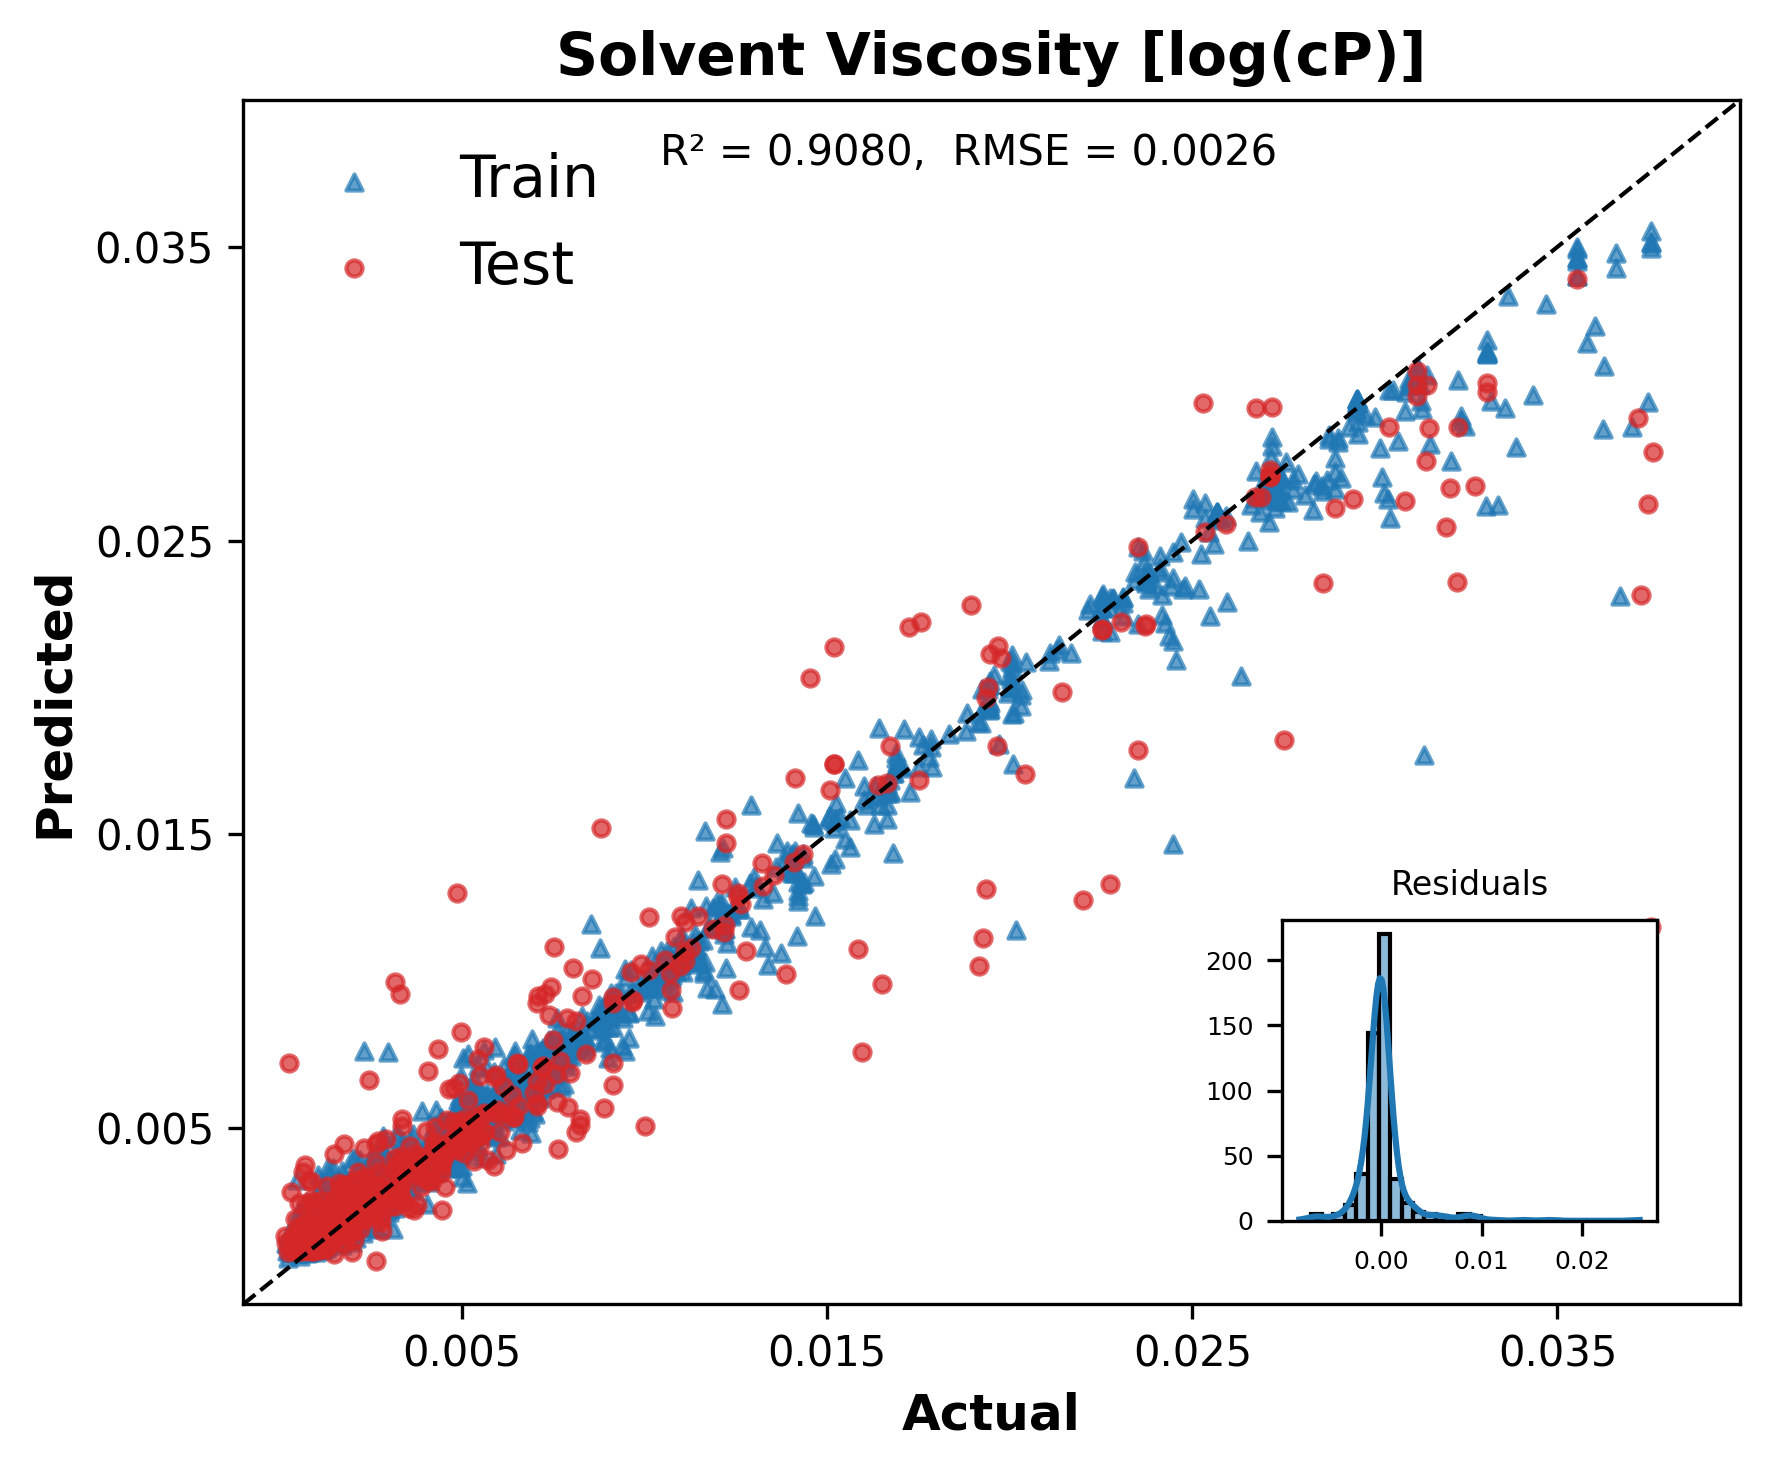

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# Invert the log transformation


fig, ax = plt.subplots(figsize=(6, 5), dpi=300)

# ➤ Scatter plots
ax.scatter(y_train_act, y_train_pred, alpha=0.7, s=15, color='tab:blue', marker='^', label='Train')
ax.scatter(y_test, y_pred, alpha=0.7, s=15, color='tab:red', marker='o', label='Test')
ax.plot([-0.001, 0.040], [-0.001, 0.040], 'k--', linewidth=1)

# ➤ Main plot labels
ax.set_title("Solvent Viscosity [log(cP)]", fontsize=14, fontweight='bold')
ax.set_xlabel("Actual", fontsize=12, fontweight='bold')
ax.set_ylabel("Predicted", fontsize=12, fontweight='bold')
ax.set_xlim(-0.001, 0.040)
ax.set_ylim(-0.001, 0.040)
ax.set_xticks([0.005, 0.015, 0.025, 0.035])
ax.set_yticks([0.005, 0.015, 0.025, 0.035])
ax.tick_params(axis='both', labelsize=10)

# ➤ R² and RMSE text
x_center = (y_test.min() + y_test.max()) / 2
y_top = y_pred.max() + (y_pred.max() - y_pred.min()) * 0.15
ax.text(x_center, y_top, f"R² = {r2:.4f},  RMSE = {rmse:.4f}",
        fontsize=10, ha='center', va='top')

# ➤ Legend
ax.legend(loc='upper left', fontsize=14, frameon=False)

# ➤ Inset plot for residuals
inset_ax = inset_axes(ax, width="25%", height="25%", loc='lower right', borderpad=2)
sns.histplot(residuals, bins=30, kde=True, ax=inset_ax)
inset_ax.set_title("Residuals", fontsize=8)
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
inset_ax.tick_params(labelsize=6)

# ➤ Save and display
plt.tight_layout()
plt.savefig("solvent_viscosity_fixed_TT.png", dpi=300, bbox_inches='tight')
plt.show()
